# Chapter 3. Simple Linear Regression: Rushing Yards Over Expected
Football is a contextual sport. Consider whether a pass is completed. This depends on multiple factors: Was the quarterback under pressure (making it harder to complete)? Was the defense expecting a pass (which would make it harder to complete)? What was the depth of the pass (completion percentage goes down with the depth of the target)?

What turns people off to football analytics are conclusions that they feel lack a contextual understanding of the game. “Raw numbers” can be misleading. Sam Bradford once set the NFL record for completion percentage in a season as a member of the Minnesota Vikings in 2016.

Luckily, given the great work of the people supporting nflfastR, you can provide your own context for metrics by applying the statistical tool known as regression. Through regression, you can normalize, or control for, variables (or features) that have been shown to affect a player’s production. Whether a feature predicts a player’s production is incredibly hard to prove in real life.

The process of normalization in both the public and private football analytics space generally requires models that are more involved than a simple linear regression, the model covered in this chapter. But we have to start somewhere. And simple linear regression provides a nice start to modeling because it is both understandable and the foundation for many other types of analyses.

Note

Many fields use simple linear regression, which leads to the use of multiple terms. Mathematically, the predictor variable is usually x, and the response variable is usually y. Some synonyms for x include predictor variable, feature, explanatory variable, and independent variable. Some synonyms for y include response variable, target, and dependent variable. Likewise, medical studies often correct for exogenous or confounding data (variables to statisticians or features to data scientists) such as education level, age, or other socioeconomic data. You are learning the same concepts in this chapter and Chapter 4 with the terms normalize and control for.

Simple linear regression consists of a model with a single explanatory variable that is assumed to be linearly related to a single dependent variable, or feature. A simple linear regression fits the statistically “best” straight line by using one independent predictor variable to estimate a response variable as a function of the predictor. Simple refers to having only one predictor variable as well an intercept, an assumption Chapter 4 shows you how to relax. Linear refers to the straight line (compared to a curved line or polynomial line for those of you who remember high school algebra).

Regression originally referred to the idea that observations will return, or regress, to the average over time, as noted by Francis Galton in 1877. For example, if a running back has above-average rushing yards per carry one year, we would statistically expect them to revert, or regress, to the league average in future years, all else being equal. The linear assumption made in many models is often onerous but is generally fine as a first pass.

To start applying simple linear regression, you are going to work on a problem that has been solved already in the public space, during the 2020 Big Data Bowl. Participants in this event used tracking data (the positioning, direction, and orientation of all 22 on-field players every tenth of a second) to model the expected rushing yards gained on a play. This value was then subtracted from a player’s actual rushing yards on a play to determine their rushing yards over expected (RYOE). As we talked about in Chapter 1, this kind of residual analysis is a cornerstone exercise in all of sports analytics. Regardless of the mechanics of the model, the broad idea is to adjust for the situation a rusher has to undergo to gain yards.

To mimic RYOE, but on a much smaller scale, you will use the yards to go on a given play. Recall that each football play has a down and distance, where down refers to the place in the four-down sequence a team is in to either pick up 10 yards or score either a touchdown or field goal. Distance, or yards to go, refers to the distance left to achieve that goal and is coded in the data as ydstogo.

A reasonable person would expect that the specific down and yards to go affect RYOE. This observation occurs because it is easier to run the ball when more yards to go exist because the defense will usually try to prevent longer plays. For example, when an offense faces third down and 10 yards to go, the defense is playing back in hopes of avoiding a big play. Conversely, while on second down and 1 yard to go, the defense is playing up to try to prevent a first down or touchdown. Metrics like RYOE help normalize the context of a running back’s plays.

Many example players exist from the history of the NFL. Mike Alstott, the Tampa Bay Buccaneers second-round pick in 1996, often served as the short-yardage back on the upstart Bucs teams of the late-1990s/early-2000s. In contrast, his backfield mate, Warrick Dunn, the team’s first-round choice in 1997, served in the “early-down” role. As a result, their yards-per-carry numbers were different as members of the same team: 3.7 yards for Alstott and 4.0 yards for Dunn. Thus, regression can help you account for that and make better comparisons to create metrics such as RYOE.

Understanding simple linear regression from this chapter also serves as a foundation for skills covered in other chapters, such as more complex RYOE models in Chapter 4, completion percentage over expected in the passing game in Chapter 5, touchdown passes per game in Chapter 6, and models used to evaluate draft data in Chapter 7. Many people, including the authors, call linear models both the workhorse and foundation for applied statistics and data science.


In [1]:
import pandas as pd
import numpy as np
np.float_ = np.float64
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# seasons = range(2016, 2022 + 1)
# pbp_py = nfl.import_pbp_data(seasons)
pbp_py = nfl.import_pbp_data(range(2020, 2024))

2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [3]:
pbp_py_run =\
    pbp_py.query('play_type == "run" & rusher_id.notnull()')\
    .reset_index()
# replace null rushing yards with 0
pbp_py_run\
    .loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

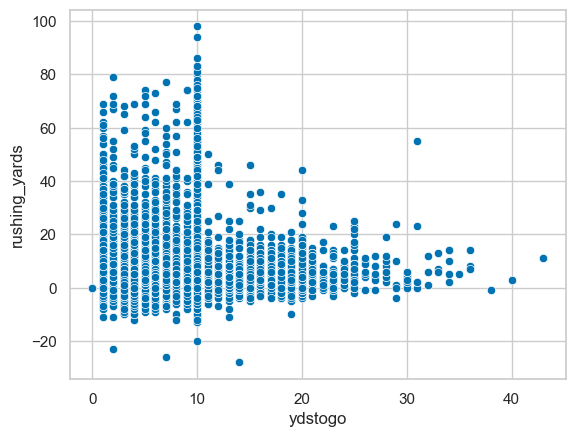

In [4]:
# take a look at the raw data first
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pbp_py_run, x="ydstogo", y="rushing_yards");
plt.show();

It’s hard to see whether a relation exists between the yards to go and the number of rushing yards gained on a play. You can do some things to make the plot easier to read. First, add a trend line to see if the data slopes upward, downward, or neither up nor down.

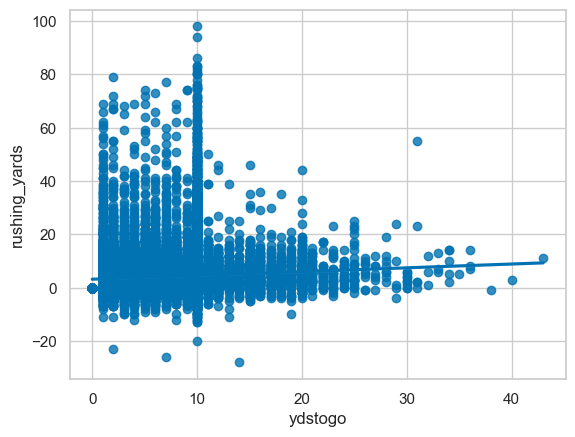

In [5]:
sns.regplot(data=pbp_py_run, x="ydstogo", y="rushing_yards");
plt.show();

You see a positive slope, albeit a very small one. This shows you that rushing gains increase slightly as yards to go increases. Another approach to try to examine the data is binning and averaging. This borrows from the ideas of a histogram, but rather than using the count for each bin, an average is used for each bin. In this case, the bins are easy to define: they are the ydstogo values, which are integers.

Now, average over each yards-per-carry value gained in each bin. In Python, aggregate the data and then plot it

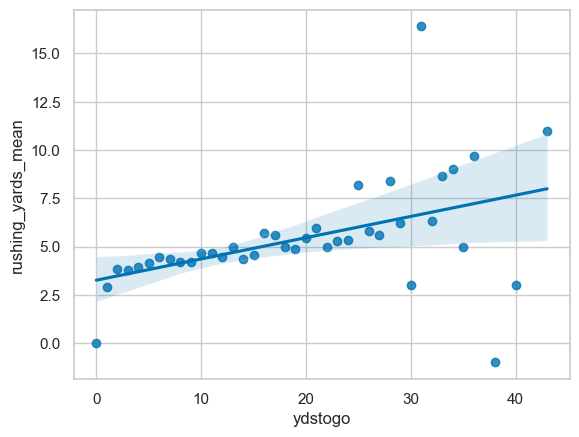

In [6]:
pbp_py_run_avg =\
    pbp_py_run.groupby(["ydstogo"])\
    .agg({"rushing_yards": ["mean"]})

pbp_py_run_avg.columns =\
    list(map("_".join, pbp_py_run_avg.columns))
pbp_py_run_avg.reset_index(inplace=True)

sns.regplot(data = pbp_py_run_avg, x = "ydstogo", y = "rushing_yards_mean");
plt.show();
# the average rushing yards gained for every ydstogo distance

You again see a positive linear relationship between average yards gained and yards to go. While binning and averaging is not a substitute for regressing along the entire dataset, the approach can give you insight into whether such an endeavor is worth doing in the first place and helps you to better “see” the data.



## Simple Linear Regression
Now that you’ve wrangled and interrogated the data, you’re ready to run a simple linear regression. Python and R use the same formula notation for the functions we show you in this book. For example, to build a simple linear regression where ydstogo predicts rushing_yards, you use the formula 

rushing_yards ~ 1 + ydstogo.

The left hand side of the formula contains the target, or response, variable. The right hand side of the formula contains the response, or predictor, variables. Chapter 4 shows how to use multiple predictors that are separated by a +.

You can read this formula as rushing_yards are *predicted by* (indicated by the tilde) an intercept (1) and a slope parameter for yards to go (ydstogo). The 1 is an optional value to explicitly tell you where the model contains an intercept. Most people do not usually include an intercept in the formula, but we include it here to help you explicitly think about this term in the model.

We are using the statsmodels package because it is better for statistical inference compared to the more popular Python package scikit-learn that is better for machine learning. Additionally, statsmodels uses similar syntax as R, which allows you to more readily compare the two languages.

In Python, use the statsmodels package’s formula.api imported as smf, to run an ordinary least-squares regression, ols(). To build the model, you will need to tell Python how to fit the regression, which is where the formula, rushing_yards ~ 1 + ydstogo, comes into play.

Using Python, build the model, fit the model, and then look at the model’s summary:

In [7]:
yard_to_go_py = \
    smf.ols(formula = 'rushing_yards ~ 1 + ydstogo', data = pbp_py_run)
print(yard_to_go_py.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     450.5
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           1.44e-99
Time:                        11:42:56   Log-Likelihood:            -1.7670e+05
No. Observations:               54806   AIC:                         3.534e+05
Df Residuals:                   54804   BIC:                         3.534e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1829      0.058     54.483      0.0

This summary output includes a description of the model. Many of the summary items should be straightforward, such as the dependent variable (Dep. Variable), Date, and Time. The number of observations (No. Observations) relates to the degrees of freedom. The degrees of freedom indicate the number of “extra” observations that exist compared to the number of parameters fit.

With this model, two parameters were fit: a slope for rushing_yards and an intercept, Intercept. Hence, the Df Residuals equals the No. Observations–2. The 
 value corresponds to how well the model fits the data. If 
, the model fits the data perfectly. Conversely, if 
 = 0, the model does not predict the data at all. In this case, the low 
 of 0.007 shows that the simple model does not predict the data well.

Other outputs of interest include the coefficient estimates for the Intercept and ydstogo. The Intercept is the number of rushing yards expected to be gained if there are 0 yards to go for a first down or a touchdown (which never actually occurs in real life). The slope for ydstogo corresponds to the expected number of additional rushing yards expected to be gained for each additional yard to go. For example, a rushing play with 2 yards to go would be expected to produce 3.2(intercept) + 0.1(slope) × 2(number of yards to go) = 3.4 yards on average.

With the coefficients, a point estimate exists (coef) as well as the standard error (std err). The standard error (SE) captures the uncertainty around the estimate for the coefficient, something Appendix B describes in greater detail. The t-value comes from a statistical distribution (specifically, the t-distribution) and is used to generate the SE and confidence interval (CI). The p-value provides the probability of obtaining the observed t-value, assuming the null hypothesis of the coefficient being 0 is true.

The p-value ties into null hypothesis significance testing (NHST), something that most introductory statistics courses cover, but is increasingly falling out of use by practicing statisticians. Lastly, the summary includes the 95% CI for the coefficients. The lower CI is the 0.025 column, and the upper CI is the 0.975 column (97.5 – 2.5 = 95%). The 95% CI should contain the true estimate for the coefficient 95% of the time, assuming the observation process is repeated many times. However, you never know which 5% of the time you are wrong.

Lastly, before moving on to look at RYOE, we need to save the residuals to create an RYOE column in the data. Residuals are the difference between a model’s expected (or predicted) output and the observed data. With pandas in Python, create a new RYOE column in the pbp_py_run dataframe from the model’s residuals:

In [8]:
pbp_py_run["ryoe"] = \
    yard_to_go_py\
    .fit()\
    .resid

The count of RYOE is the number of carries a rusher has.

The sum of RYOE is the total RYOE.

The mean of RYOE is the RYOE per carry.

The mean of rushing yards is the yards per carry.

In [9]:
ryoe_py = \
    pbp_py_run\
    .groupby(['season', 'rusher_id', 'rusher'])\
    .agg({'ryoe' : ['count', 'sum', 'mean'],
         'rushing_yards' : 'mean'})

ryoe_py.columns = \
    list(map('_'.join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)

ryoe_py =\
    ryoe_py\
    .rename(columns={
        "ryoe_count": "n",
        "ryoe_sum": "ryoe_total",
        "ryoe_mean": "ryoe_per",
        "rushing_yards_mean": "yards_per_carry"})

ryoe_py = ryoe_py.query("n > 50")

print(ryoe_py.sort_values("ryoe_total", ascending=False))

      season   rusher_id       rusher    n  ryoe_total  ryoe_per  \
664     2021  00-0036223     J.Taylor  332  405.546653  1.221526   
115     2020  00-0032764      D.Henry  397  345.690139  0.870756   
1459    2023  00-0039040     D.Achane  109  326.566030  2.996019   
1180    2023  00-0033280  C.McCaffrey  331  319.309827  0.964682   
149     2020  00-0033293      A.Jones  222  279.641748  1.259648   
...      ...         ...          ...  ...         ...       ...   
7       2020  00-0023500       F.Gore  187 -165.417475 -0.884585   
1374    2023  00-0037256      R.White  299 -180.421351 -0.603416   
1362    2023  00-0036997   J.Williams  219 -184.209731 -0.841140   
1277    2023  00-0035700     J.Jacobs  233 -199.197079 -0.854923   
1375    2023  00-0037258     D.Pierce  148 -242.056176 -1.635515   

      yards_per_carry  
664          5.454819  
115          5.206549  
1459         7.422019  
1180         5.217523  
149          5.540541  
...               ...  
7            3.

In [10]:
print(ryoe_py.sort_values("ryoe_per", ascending=False))

      season   rusher_id     rusher    n  ryoe_total  ryoe_per  \
910     2022  00-0034796  L.Jackson   73  274.036468  3.753924   
1459    2023  00-0039040   D.Achane  109  326.566030  2.996019   
235     2020  00-0034796  L.Jackson  121  245.072571  2.025393   
572     2021  00-0034750    R.Penny  119  223.469279  1.877893   
1052    2022  00-0036945   J.Fields   85  157.013083  1.847213   
...      ...         ...        ...  ...         ...       ...   
1186    2023  00-0033308   M.Breida   55  -87.244444 -1.586263   
1315    2023  00-0036414    C.Akers   60  -96.429764 -1.607163   
1375    2023  00-0037258   D.Pierce  148 -242.056176 -1.635515   
651     2021  00-0035860    T.Jones   54  -88.640125 -1.641484   
697     2021  00-0036414    C.Akers   72 -143.026895 -1.986485   

      yards_per_carry  
910          7.821918  
1459         7.422019  
235          6.264463  
572          6.294117  
1052         6.000000  
...               ...  
1186         2.745455  
1315         2.

A reasonable question we should ask is whether total yards or yards per carry is a better measure of a player’s ability. Fantasy football analysts and draft analysts both carry a general consensus that “volume is earned.” The idea is that a hidden signal is in the data when a player plays enough to generate a lot of carries.

Data is an incomplete representation of reality, and players do things that aren’t captured. If a coach plays a player a lot, it’s a good indication that that player is good. Furthermore, a negative relationship generally exists between volume and efficiency for that same reason. If a player is good enough to play a lot, the defense is able to key on him more easily and reduce his efficiency. This is why we often see backup running backs with high yards-per-carry values relative to the starter in front of them (for example, look at Tony Pollard and Ezekiel Elliott for the Dallas Cowboys in 2019–2022). Other factors are at play as well (such as Zeke’s draft status and contract) that don’t necessarily make volume the be-all and end-all, but it’s important to inspect.

In [15]:
#  keep only columns needed
cols_keep =\
    ["season", "rusher_id", "rusher",
     "ryoe_per", "yards_per_carry"]

# create current dataframe
ryoe_now_py =\
    ryoe_py[cols_keep].copy()

# create last-year's dataframe
ryoe_last_py =\
    ryoe_py[cols_keep].copy()

# rename columns
ryoe_last_py\
    .rename(columns = {'ryoe_per': 'ryoe_per_last',
                       'yards_per_carry': 'yards_per_carry_last'},
                       inplace=True)

# add 1 to season so the previous season's data points
# will be in the same row as the current season
ryoe_last_py["season"] += 1

# merge together
ryoe_lag_py =\
    ryoe_now_py\
    .merge(ryoe_last_py,
           how='inner',
           on=['rusher_id', 'rusher',
               'season'])

In [16]:
ryoe_lag_py[["yards_per_carry_last", "yards_per_carry"]].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.000000,0.327179
yards_per_carry,0.327179,1.000000


In [17]:
ryoe_lag_py[["ryoe_per_last", "ryoe_per"]].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.347343
ryoe_per,0.347343,1.000000


These results show that, for players with more than 50 rushing attempts in back-to-back seasons, this version of RYOE per carry is slightly more stable year to year than yards per carry (because the correlation coefficient is larger). Therefore, yards per carry includes information inherent to the specific play in which a running back carries the ball. Furthermore, this information can vary from year to year. After extracted out, our new metric for running back performance is slightly more predictive year to year.

As far as the question of whether (or, more accurately, how much) running backs matter, the difference between our correlation coefficients suggest that we don’t have much in the way of a conclusion to be drawn so far. Prior to this chapter, you’ve really looked at statistics for only one position (quarterback), and the more stable metric in the profile for that position (yards per pass attempt on short passes, with r values nearing 0.5) is much more stable than yards per carry and RYOE. Furthermore, you haven’t done a thorough analysis of the running game relative to the passing game, which is essential to round out any argument that running backs are or are not important.

The key questions for football analysts about running backs are as follows:

Are running back contributions valuable?

Are their contributions repeatable across years?

In Chapter 4, you will add variables to control for other factors affecting the running game. For example, the down part of down and distance is surely important, because a defense will play even tighter on fourth down and 1 yard to go than it will on third down and that same 1 yard to go. A team trailing (or losing) by 14 points will have an easier time of running the ball than a team up by 14 points (all else being equal) because a team that is ahead might be playing “prevent” defense, a defense that is willing to allow yards to their opponent, just not too many yards.